# Advanced Certification Program in Computational Data Science
## A program by IISc and TalentSprint
### Assignment 7: Autoencoders

## Learning Objectives

At the end of the experiment, you will be able to

* know what are autoencoders
* know different kinds of autoencoders: stacked, and denoising
* perform dimensionality reduction using autoencoder
* perform anomaly detection using autoencoder

## Information

Autoencoders are artificial neural networks capable of learning dense representations of the input data, called **latent representations** or **codings**, without any supervision (unlabeled training set). These codings typically have a much lower dimensionality than the input data, making autoencoders useful for dimensionality reduction.

Autoencoders also act as feature detectors, and they can be used for unsupervised pretraining of deep neural networks. Some autoencoders are generative models: they are capable of randomly generating new data that looks very similar to the training data.

**Working of autoencoders:**

Autoencoders learn to copy their inputs to their outputs, by constraining the network in various ways, such as, by limiting the size of the latent representations, or by adding noise to the inputs and train the network to recover the original inputs. These constraints force the autoencoder to learn efficient ways of representing the data and prevent it from trivially copying the inputs directly to the outputs. In short, the codings are byproducts of the autoencoder learning the identity function under some constraints.

An autoencoder is composed of two parts: 

* an **encoder** (or recognition network) that converts the inputs to a latent representation, followed by 

* a **decoder** (or generative network) that converts the internal representation to the outputs.
<br><br>
<center>
<img src="https://miro.medium.com/max/1400/1*V_YtxTFUqDrmmu2JqMZ-rA.png" width=600px/>
</center>
<br><br>

An autoencoder has the same architecture as a Multi-Layer Perceptron, except that the number of neurons in the input and output layers must be equal. The outputs are often called the **reconstructions**, and the cost function contains a **reconstruction loss** that penalizes the model when the reconstructions are different from the inputs.

When the internal representation has a lower dimensionality than the input data as shown in the figure below, the autoencoder is said to be **Undercomplete Autoencoder**.

<br><br>
<center>
<img src="https://www.compthree.com/images/blog/ae/ae.png" width=500px/>
</center>

$\hspace{10.8cm} \text{A Simple Autoencoder}$
<br><br>

Let’s see how to implement dimensionality reduction using an undercomplete autoencoder having multiple hidden layers.

### Setup Steps:

### Import required packages

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import losses
from tensorflow.keras.layers import Input, Flatten, Dense, Reshape, GaussianNoise, Dropout
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

### Stacked Autoencoders

When autoencoders have multiple hidden layers, they are called **stacked autoencoders** (or **deep autoencoders**). Adding more layers helps the autoencoder learn more complex codings. The architecture of a stacked autoencoder is typically **symmetrical** with regard to the central hidden layer (the coding layer).

For example, an autoencoder for MNIST may have 784 inputs, followed by a hidden layer with 300 neurons, then a central hidden layer of 150 neurons, then another hidden layer with 300 neurons, and an output layer with 784 neurons. This stacked autoencoder is represented in the figure below.

<br><br>
<center>
<img src="https://www.programmersought.com/images/827/3a4063a8e0c49eae7a3f6c4af55df64b.png" width=550px/>
</center>

$\hspace{9.55cm} \text{Stacked Autoencoder}$
<br><br>

#### Implementing a Stacked Autoencoder Using Keras

Let's use Fashion MNIST dataset:

In [5]:
# Load fasion mnist dataset
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

# Scale dataset
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

# Training and validation set
X_train = X_train_full[:-5000]
X_valid = X_train_full[-5000:]
y_train = y_train_full[:-5000]
y_valid = y_train_full[-5000:]

4431872/4422102 [==============================] - 0s 0us/step


Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders).

In [6]:
# Create stacked encoder
stacked_encoder = Sequential([
                              Flatten(input_shape=[28, 28]),
                              Dense(100, activation="selu"),
                              Dense(30, activation="selu"),
                              ])

# Create stacked decoder
stacked_decoder = Sequential([
                              Dense(100, activation="selu", input_shape=[30]),
                              Dense(28 * 28, activation="sigmoid"),
                              Reshape([28, 28])
                              ])

# Create stacked autoencoder
stacked_ae = Sequential([stacked_encoder, stacked_decoder])

# Compile model
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

stacked_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate = 1.5), metrics = [rounded_accuracy])

In [7]:
# Train stacked autoencoder on training set
history = stacked_ae.fit(X_train, X_train, epochs=20, validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 10s 5ms/step - loss: 0.3372 - rounded_accuracy: 0.8875 - val_loss: 0.3119 - val_rounded_accuracy: 0.9099
Epoch 2/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3052 - rounded_accuracy: 0.9156 - val_loss: 0.3039 - val_rounded_accuracy: 0.9202
Epoch 3/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2984 - rounded_accuracy: 0.9217 - val_loss: 0.2970 - val_rounded_accuracy: 0.9247
Epoch 4/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2946 - rounded_accuracy: 0.9250 - val_loss: 0.2938 - val_rounded_accuracy: 0.9271
Epoch 5/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2921 - rounded_accuracy: 0.9273 - val_loss: 0.2918 - val_rounded_accuracy: 0.9292
Epoch 6/20
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2902 - rounded_accuracy: 0.9290 - val_loss: 0.2913 - val_rounded_accuracy: 0.9312
Epoch 7/20
1719/1719 [=================

For creating stacked autoencoder:

* We split the autoencoder model into two submodels: the encoder and the decoder.

* The encoder takes 28 × 28–pixel grayscale images, flattens them as a vector of size 784, then processes these vectors through two Dense layers of diminishing sizes (100 units then 30 units), both using the SELU activation function. For each input image, the encoder outputs a vector of size 30.

* The decoder takes codings of size 30 (output by the encoder) and processes them through two Dense layers of increasing sizes (100 units then 784 units), and it reshapes the final vectors into 28 × 28 arrays so the decoder’s outputs have the same shape as the encoder’s inputs.

* When compiling the stacked autoencoder, we use the binary cross-entropy loss instead of the mean squared error. We are treating the reconstruction task as a multilabel binary classification problem: each pixel intensity represents the probability that the pixel should be black. Framing it this way (rather than as a regression problem) tends to make the model converge faster.

* Finally, we train the model using X_train as both the inputs and the targets (and similarly, we use X_valid as both the validation inputs and targets).

To compare the inputs and the outputs, let’s plot a few images from the validation set, as well as their reconstructions:

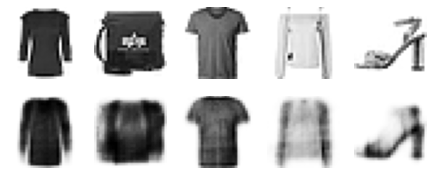

In [8]:
def show_reconstructions(model, images=X_valid, n_images=5):
    ''' Compare inputs and outputs of model using n_images from X_valid dataset '''

    reconstructions = model.predict(images[:n_images])

    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for img_idx in range(n_images):
        plt.subplot(2, n_images, 1 + img_idx)
        plt.imshow(images[img_idx], cmap='binary')
        plt.axis("off")

        plt.subplot(2, n_images, 1 + n_images + img_idx)
        plt.imshow(reconstructions[img_idx], cmap='binary')
        plt.axis("off")

# Visualize reconstructions
show_reconstructions(model = stacked_ae)

From the above results, we can see that the reconstructions are recognizable, but a bit too lossy. We may need to train the model for longer, or make the encoder and decoder deeper, or make the codings larger.

<font color='blue'>**Discussion 1:** We train the stacked autoencoder using X_train as both the inputs and the targets but for training the encoder we use X_train as the input only. Why? </font>

#### Visualizing Fashion MNIST

We can use trained stacked autoencoder to reduce the dataset’s dimensionality. One big advantage of autoencoders is that they can handle large datasets, with many instances and many features. So we can use an autoencoder to reduce the dimensionality down to a reasonable level, then use another dimensionality reduction algorithm for visualization. 

Let’s use this strategy to visualize Fashion MNIST. First, we use the encoder from our stacked autoencoder to reduce the dimensionality down to 30, then we use Scikit-Learn’s t-SNE algorithm to reduce the dimensionality down to 2 for visualization:

In [9]:
# Predict codings
X_valid_compressed = stacked_encoder.predict(X_valid)

# Implement t-SNE
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)

# Normalize 
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


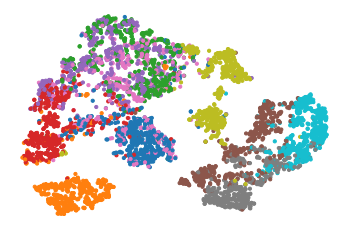

In [10]:
# Visualize Fashion MNIST
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

From the above plot, we can see that the t-SNE algorithm identified several clusters which match the classes reasonably well (each class is represented with a different color).

Till now, in order to force the autoencoder to learn interesting features, we have limited the size of the coding layer, making it undercomplete. Other kinds of constraints allow the coding layer to be just as large as the inputs, or even larger, resulting in an **overcomplete autoencoder**, such as:

* Denoising Autoencoders

### Denoising Autoencoders

Another way to force the autoencoder to learn useful features is to add noise to its inputs, and training it to recover the original, noise-free inputs. In a 2008 paper, Pascal Vincent et al. showed that autoencoders could also be used for feature extraction. In a 2010 paper, Vincent et al. introduced stacked denoising autoencoders. 

The noise can be 

* pure **Gaussian noise** added to the inputs, or 

* randomly switched-off inputs, just like in **dropout** 

The below figure shows both options.
<br><br>
<center>
<img src="https://www.programmersought.com/images/233/76dabd18e2cc55b6f6e9969220005ce9.png" width=500px/>
</center>

$\hspace{5.5cm} \text{Denoising autoencoders, with Gaussian noise (left) and dropout (right)}$
<br><br>

Let's implement denoising autoencoder to the Fashion MNIST dataset.

Using Gaussian noise:

In [13]:
# Create denoising encoder
denoising_encoder = Sequential([
                                Flatten(input_shape=[28, 28]),
                                GaussianNoise(0.2),
                                Dense(100, activation="selu"),
                                Dense(30, activation="selu")
                                ])
# Create denoising decoder
denoising_decoder = Sequential([
                                Dense(100, activation="selu", input_shape=[30]),
                                # YOUR CODE HERE for adding a Dense layer
                                Dense(28 * 28, activation="selu"),
                                Reshape([28, 28])
                                ])
# Create denoising autoencoder
denoising_ae = Sequential([denoising_encoder , denoising_decoder])

# Compile model
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=0.1), metrics=[rounded_accuracy])

In [14]:
# Train denoising autoencoder on training set
history = denoising_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 11s 6ms/step - loss: 5.9280 - rounded_accuracy: 0.6089 - val_loss: 6.1047 - val_rounded_accuracy: 0.6040
Epoch 2/10
1719/1719 [==============================] - 10s 6ms/step - loss: 6.0882 - rounded_accuracy: 0.6052 - val_loss: 6.0870 - val_rounded_accuracy: 0.6052
Epoch 3/10
1719/1719 [==============================] - 10s 6ms/step - loss: 6.0677 - rounded_accuracy: 0.6065 - val_loss: 6.0727 - val_rounded_accuracy: 0.6061
Epoch 4/10
1719/1719 [==============================] - 10s 6ms/step - loss: 6.0665 - rounded_accuracy: 0.6066 - val_loss: 6.0727 - val_rounded_accuracy: 0.6061
Epoch 5/10
1719/1719 [==============================] - 10s 6ms/step - loss: 6.0665 - rounded_accuracy: 0.6066 - val_loss: 6.0727 - val_rounded_accuracy: 0.6061
Epoch 6/10
1719/1719 [==============================] - 10s 6ms/step - loss: 6.0665 - rounded_accuracy: 0.6066 - val_loss: 6.0727 - val_rounded_accuracy: 0.6061
Epoch 7/10
1719/1719 [============

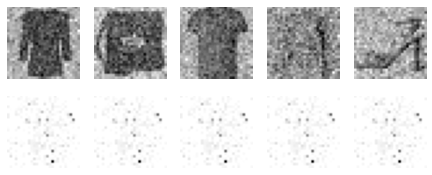

In [15]:
# Visualize reconstructions
noise = GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, training=True))

<font color='blue'>**Discussion 2:** In the above code cell, why do we need to pass X_valid to a separate `GaussianNoise` layer, although a `GaussianNoise` layer is already there in denoising_encoder submodel? </font>

Using dropout:

In [16]:
# Create encoder
dropout_encoder = Sequential([
                              Flatten(input_shape=[28, 28]),
                              Dropout(0.5),
                              Dense(100, activation="selu"),
                              Dense(30, activation="selu")
                              ])
# Create decoder
dropout_decoder = Sequential([
                              Dense(100, activation="selu", input_shape=[30]),
                              Dense(28 * 28, activation="selu"),
                              Reshape([28,28])

])

# Create autoencoder
dropout_ae = Sequential([dropout_encoder,dropout_decoder])

# Compile model
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0), metrics=[rounded_accuracy])

In [17]:
# Training autoencoder on training set
history = dropout_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 10s 6ms/step - loss: 4.9926 - rounded_accuracy: 0.6655 - val_loss: 4.8039 - val_rounded_accuracy: 0.6762
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 4.7535 - rounded_accuracy: 0.6778 - val_loss: 4.7836 - val_rounded_accuracy: 0.6740
Epoch 3/10
1719/1719 [==============================] - 10s 6ms/step - loss: 4.7349 - rounded_accuracy: 0.6782 - val_loss: 4.7467 - val_rounded_accuracy: 0.6783
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 4.7149 - rounded_accuracy: 0.6806 - val_loss: 4.7419 - val_rounded_accuracy: 0.6786
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 4.7128 - rounded_accuracy: 0.6808 - val_loss: 4.7418 - val_rounded_accuracy: 0.6786
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 4.7128 - rounded_accuracy: 0.6808 - val_loss: 4.7418 - val_rounded_accuracy: 0.6786
Epoch 7/10
1719/1719 [================

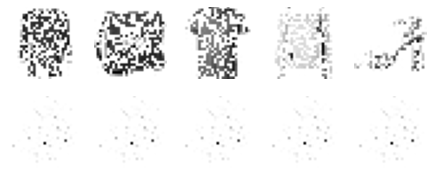

In [18]:
# Visualize reconstructions
dropout = Dropout(0.5)
show_reconstructions(dropout_ae, dropout(X_valid, training=True))

### Anomaly Detection using Autoencoder

One practical application of autoencoders is anomaly detection. 

Let's see how to use autoencoder for detecting anomalies in ECG (electrocardiogram) readings.

In [19]:
# Read ecg dataset
df = pd.read_csv('ecg.csv', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818287,-1.250522,-0.477492,-0.363808,-0.491957,-0.421855,-0.309201,-0.495939,-0.342119,-0.355336,-0.367913,-0.316503,-0.412374,-0.471672,-0.413458,-0.364617,-0.449298,-0.471419,-0.424777,-0.462517,-0.552472,-0.475375,-0.694200,-0.701868,-0.593812,-0.660684,-0.713831,-0.769807,-0.672282,-0.653676,-0.639406,-0.559302,-0.591670,...,1.258179,1.433789,1.700533,1.999043,2.125341,1.993291,1.932246,1.797437,1.522284,1.251168,0.998730,0.483722,0.023132,-0.194914,-0.220917,-0.243737,-0.254695,-0.291136,-0.256490,-0.227874,-0.322423,-0.289286,-0.318170,-0.363654,-0.393456,-0.266419,-0.256823,-0.288694,-0.162338,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,0.148951,0.183527,0.294876,0.190233,0.235575,0.253487,0.221742,0.050233,0.178042,0.139563,0.046794,0.043007,0.106544,0.012654,0.003995,0.045724,-0.045999,-0.072667,-0.071078,-0.153866,-0.227254,-0.249270,-0.253489,-0.332835,-0.264330,-0.345825,-0.310781,-0.334160,-0.306178,-0.174563,...,1.808428,2.164346,2.070747,1.903614,1.764455,1.507769,1.293428,0.894562,0.578016,0.244343,-0.286443,-0.515881,-0.732707,-0.832465,-0.803318,-0.836252,-0.777865,-0.774753,-0.733404,-0.721386,-0.832095,-0.711982,-0.751867,-0.757720,-0.853120,-0.766988,-0.688161,-0.519923,0.039406,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490658,-1.183580,-0.394229,-0.282897,-0.356926,-0.287297,-0.399489,-0.473244,-0.379048,-0.399039,-0.178594,-0.339522,-0.498447,-0.337251,-0.425480,-0.423952,-0.463170,-0.493253,-0.549749,-0.529831,-0.530935,-0.502365,-0.417368,-0.526346,-0.471005,-0.676784,-0.898612,-0.610571,-0.530164,-0.765674,-0.581937,-0.537848,-0.556386,...,1.810988,2.185398,2.262985,2.052920,1.890488,1.793033,1.564784,1.234619,0.900302,0.551957,0.258222,-0.128587,-0.092585,-0.168606,-0.495989,-0.395034,-0.328238,-0.448138,-0.268230,-0.456415,-0.357867,-0.317508,-0.434112,-0.549203,-0.324615,-0.268082,-0.220384,-0.117429,0.614059,1.284825,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,-0.183319,-0.101657,-0.273874,-0.127818,-0.195983,-0.213523,-0.176473,-0.156932,-0.149172,-0.181510,-0.180074,-0.246151,-0.274260,-0.140960,-0.277449,-0.382549,-0.311937,-0.360093,-0.405968,-0.571433,-0.524106,-0.537886,-0.606778,-0.661446,-0.683375,-0.746683,-0.635662,-0.625231,-0.540094,-0.674995,...,1.772155,2.000769,1.925003,1.898426,1.720953,1.501711,1.422492,1.023225,0.776341,0.504426,0.056382,-0.233161,-0.406388,-0.327528,-0.460868,-0.402536,-0.345752,-0.354206,-0.439959,-0.425326,-0.439789,-0.451835,-0.395926,-0.448762,-0.391789,-0.376307,-0.461069,-0.253524,0.213006,0.491173,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,-0.298107,-0.428928,-0.491351,-0.361304,-0.339296,-0.324952,-0.290113,-0.363051,-0.525684,-0.597423,-0.575523,-0.567503,-0.504555,-0.618406,-0.682814,-0.743849,-0.815588,-0.826902,-0.782374,-0.929462,-0.999672,-1.060969,-1.007877,-1.028735,-1.122629,-1.028650,-1.046515,-1.063372,-1.122423,-0.983242,...,1.155363,1.336254,1.627534,1.717594,1.696487,1.741686,1.674078,1.546928,1.331738,1.110168,0.922210,0.521777,0.154852,-0.123861,-0.202998,-0.247956,-0.219122,-0.214695,-0.319215,-0.198597,-0.151618,-0.129593,-0.074939,-0.

As we can see that the dataset has 140 columns which represent the ECG readings and a labels column that has been encoded to 0 or 1 showing whether the ECG is abnormal or normal.

In [20]:
# Separate the data and labels
data = df.iloc[:,:-1].values
labels = df.iloc[:,-1].values
labels

array([1., 1., 1., ..., 0., 0., 0.])

In [21]:
# Split into training and test data
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = 0.2, random_state = 21)

Let's normalize the data to the range 0 to 1.

In [22]:
# Calculate the maximum and minimum value from the training set 
min = tf.reduce_min(train_data)
max = tf.reduce_max(train_data)

# Normalize data using the formula (data - min)/(max - min)
train_data = (train_data - min)/(max - min)
test_data = (test_data - min)/(max-min)

# Converted the data into float
train_data = tf.cast(train_data, dtype=tf.float32)
test_data = tf.cast(test_data, dtype=tf.float32)

The labels are either 0 or 1, so we will convert them into boolean (true or false) and separate the data for normal ECG from that of abnormal ones.

In [25]:
# Convert labels into boolean 
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

# Normal ECG data
n_train_data = train_data[train_labels]
n_test_data = test_data[test_labels]

# Abnormal ECG data
an_train_data = train_data[~train_labels]
an_test_data = test_data[~test_labels]

print(n_train_data)

tf.Tensor(
[[0.57030463 0.46561658 0.29058117 ... 0.48504233 0.4233502  0.47598344]
 [0.48320588 0.28246963 0.16471253 ... 0.567567   0.4677294  0.2692329 ]
 [0.48144642 0.35151404 0.25972766 ... 0.5479421  0.5077544  0.54298663]
 ...
 [0.41039047 0.24164985 0.13120876 ... 0.5277313  0.5654091  0.5023885 ]
 [0.5397748  0.4140786  0.28101394 ... 0.51266515 0.43706053 0.4426865 ]
 [0.29639772 0.15988176 0.18883787 ... 0.53766966 0.545786   0.40826708]], shape=(2359, 140), dtype=float32)


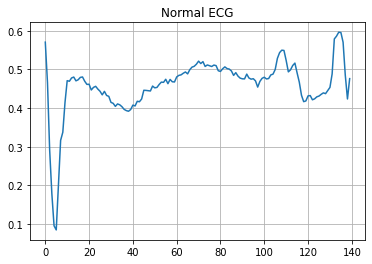

In [26]:
# Visualize a normal ECG
plt.plot(np.arange(140), n_train_data[0])
plt.grid()
plt.title('Normal ECG')
plt.show()

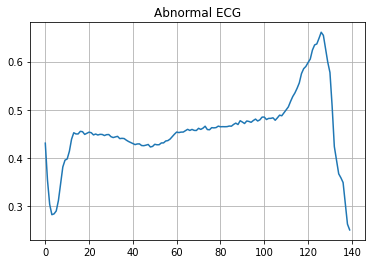

In [28]:
# Visualize an abnormal ECG
plt.plot(np.arange(140), an_train_data[0])
plt.grid()
plt.title("Abnormal ECG")
plt.show()

**How will the model detect an anomaly?**

We will create an encoder and a decoder using an ANN architecture. We are going to provide the ECG data as input and the model will try to reconstruct it. The error between the original data and the reconstructed output will be called the **reconstruction error**. Based on this reconstruction error we are going to classify an ECG as anomalous or not. 

To do this, we are going to train the model only on the normal ECG data but it will be tested on the full test set so that when an abnormal ECG is provided in the input the autoencoder will try to reconstruct it but since it has been only trained on normal ECG data the output will have a larger reconstruction error. We will also define a minimum threshold for the error i.e. if the reconstruction error is above the threshold then it will be categorized as anomalous.

In [36]:
# Create encoder submodel
encoder = Sequential([Dense(32, activation='relu', input_shape=[140]),
                      Dense(16, activation='relu'),
                      Dense(8, activation='relu')
                      ])

# Create decoder submodel
decoder = Sequential([
                      Dense(16, activation="relu", input_shape=[8]),
                      Dense(32, activation="relu"),
                      Dense(140, activation="sigmoid")
])

# Create autoencoder
autoencoder = Sequential([encoder,decoder])

# Compile model
autoencoder.compile(optimizer='adam', loss='mae')

# Fit model
autoencoder.fit(n_train_data, n_train_data, epochs = 20, batch_size=512, validation_data=(n_test_data, n_test_data))

Epoch 1/20
5/5 [==============================] - 1s 40ms/step - loss: 0.0578 - val_loss: 0.0567
Epoch 2/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0559 - val_loss: 0.0543
Epoch 3/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0532 - val_loss: 0.0510
Epoch 4/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0496 - val_loss: 0.0471
Epoch 5/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0457 - val_loss: 0.0432
Epoch 6/20
5/5 [==============================] - 0s 15ms/step - loss: 0.0419 - val_loss: 0.0395
Epoch 7/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0384 - val_loss: 0.0363
Epoch 8/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0353 - val_loss: 0.0335
Epoch 9/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0327 - val_loss: 0.0311
Epoch 10/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0306 - val_loss: 0.0293
Epoch 11/20
5/5 [============

Now let's define a function in order to plot the original ECG and reconstructed ones and also show the error.

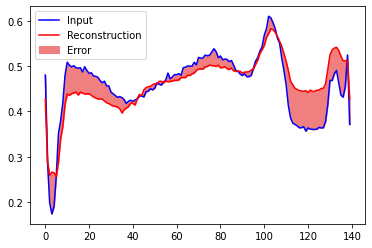

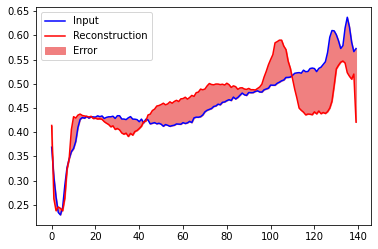

In [37]:
def plot(data, n):
    ''' Plot the original ECG and reconstructed ECG along with the error '''
    enc_img = encoder(data)
    dec_img = decoder(enc_img)
    plt.plot(data[n], 'b')
    plt.plot(dec_img[n], 'r')
    plt.fill_between(np.arange(140), data[n], dec_img[n], color = 'lightcoral')
    plt.legend(labels=['Input', 'Reconstruction', 'Error'])
    plt.show()

plot(n_test_data, 0)
plot(an_test_data, 0)

As we mentioned earlier an ECG is anomalous if it is greater than a threshold. We can set the threshold in any way we want. Here we set it to one standard deviation from the mean of normal training data.

In [38]:
# Compute threshold
reconstructed = autoencoder(n_train_data)
train_loss = losses.mae(reconstructed, n_train_data)
t = np.mean(train_loss) + np.std(train_loss)
print(t)

0.03317462


In [39]:
def prediction(model, data, threshold):
    ''' Returns True if the reconstruction error is below the threshold '''
    rec = model(data)
    loss = losses.mae(rec, data)
    return tf.math.less(loss, threshold)

pred = prediction(autoencoder, n_test_data, t)
print(pred)

tf.Tensor(
[False  True  True False  True  True  True False  True  True  True  True
  True  True  True  True  True  True  True  True False  True  True  True
  True  True  True  True  True  True  True  True  True  True False  True
  True  True  True False  True  True  True  True  True  True  True  True
  True  True  True  True False  True  True  True  True  True  True  True
  True  True  True  True False  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False  True  True  True  True
 False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  Tr

From the above results, we can see that for the normal ECG test dataset, only few of the instances are marked as False i.e, above threshold. 

Let's see some more results visually.

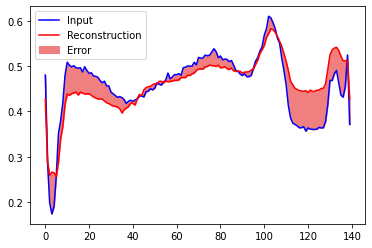

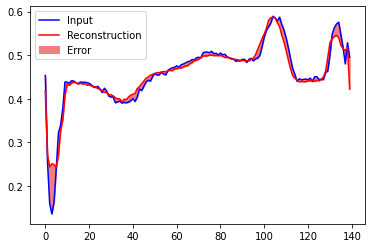

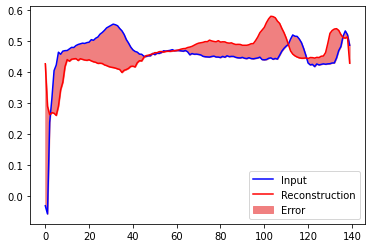

In [40]:
# Visualize some normal ECG test instances
plot(n_test_data, 0)
plot(n_test_data, 1)
plot(n_test_data, 3)

From the above results, we can see that the model can be improved by hyperparameter tuning. Also, the criteria for determining the threshold can be changed for getting better and more accurate results.

### Theory Questions

1. What are the main tasks that autoencoders are used for?

 Here are some of the main tasks that autoencoders are used for:
  * Feature extraction
  * Unsupervised pretraining
  * Dimensionality reduction
  * Generative models
  * Anomaly detection (an autoencoder is generally bad at reconstructing outliers)

2. Suppose you want to train a classifier, and you have plenty of unlabeled training data but only a few thousand labeled instances. How can autoencoders help? How would you proceed?

 If you want to train a classifier and you have plenty of unlabeled training data but only a few thousand labeled instances, then you could first train a deep autoencoder on the full dataset (labeled + unlabeled), then reuse its lower half for the classifier (i.e., reuse the layers up to the codings layer, included) and train the classifier using the labeled data. If you have little labeled data, you probably want to freeze the reused layers when training the classifier.

3. If an autoencoder perfectly reconstructs the inputs, is it necessarily a good
autoencoder? How can you evaluate the performance of an autoencoder?

 The fact that an autoencoder perfectly reconstructs its inputs does not necessarily mean that it is a good autoencoder; perhaps it is simply an overcomplete autoencoder that learned to copy its inputs to the codings layer and then to the outputs. However, if it produces very bad reconstructions, then it is almost guaranteed to be a bad autoencoder. 

 To evaluate the performance of an autoencoder, one option is to measure the
reconstruction loss (e.g., compute the MSE, or the mean square of the outputs
minus the inputs). Again, a high reconstruction loss is a good sign that the
autoencoder is bad, but a low reconstruction loss is not a guarantee that it is
good. You should also evaluate the autoencoder according to what it will be used
for. For example, if you are using it for unsupervised pretraining of a classifier, then you should also evaluate the classifier’s performance.

4. What are undercomplete and overcomplete autoencoders? What is the main risk
of an excessively undercomplete autoencoder? What about the main risk of an
overcomplete autoencoder?

 An undercomplete autoencoder is one whose codings layer is smaller than the
input and output layers. If it is larger, then it is an overcomplete autoencoder. The main risk of an excessively undercomplete autoencoder is that it may fail to reconstruct the inputs. The main risk of an overcomplete autoencoder is that it may just copy the inputs to the outputs, without learning any useful features.

5. How do you tie weights in a stacked autoencoder? What is the point of doing so?

 To tie the weights of an encoder layer and its corresponding decoder layer, you
simply make the decoder weights equal to the transpose of the encoder weights.
This reduces the number of parameters in the model by half, often making training converge faster with less training data and reducing the risk of overfitting the training set.

6. What is a generative model? Can you name a type of generative autoencoder?

 A generative model is a model capable of randomly generating outputs that
resemble the training instances. For example, once trained successfully on the
MNIST dataset, a generative model can be used to randomly generate realistic
images of digits. The output distribution is typically similar to the training data. For example, since MNIST contains many images of each digit, the generative model would output roughly the same number of images of each digit. Some generative models can be parametrized—for example, to generate only some
kinds of outputs. An example of a generative autoencoder is the variational
autoencoder.